### Remember, Discriminator doesnt have to be opposite of Generator, they are 2 different CNN networks.

In [18]:
import torch
import torch.nn as nn

# Define the number of classes and embedding size
num_classes = 10
embedding_dim = 784  # For example, 28*28

# Create the embedding layer
embedding = nn.Embedding(num_classes, embedding_dim)

# Generate an example input tensor of shape (50, 1)
# Each value is an index between 0 and num_classes-1
input_tensor = torch.randint(0, num_classes, (64,)) # Labels are just 1D vectors of size 64 when used in the training loop

# Pass the input tensor through the embedding layer
embedded_output = embedding(input_tensor)

# Display the input and output shapes and a sample output
print("Input Tensor Shape:", input_tensor.shape)
print("Embedded Output Shape:", embedded_output.shape)
print("\nSample Embedded Output for the First Index:")
print("Embedding output:", embedded_output.shape)
print("Generator Embedding shape:", embedded_output.unsqueeze(2).unsqueeze(3).shape)
print("Discriminator Embedding shape:", embedded_output.view(64, 1, 28, 28).shape)


Input Tensor Shape: torch.Size([64])
Embedded Output Shape: torch.Size([64, 784])

Sample Embedded Output for the First Index:
Embedding output: torch.Size([64, 784])
Generator Embedding shape: torch.Size([64, 784, 1, 1])
Discriminator Embedding shape: torch.Size([64, 1, 28, 28])


What does nn.Embedding(10, 28*28) do?

The nn.Embedding layer in PyTorch is used to map indices (usually representing words, tokens, or categorical variables) to dense vectors of a specified size.

Here's a breakdown of what nn.Embedding(10, 28*28) does:
1. Parameters:

    10: The number of distinct indices or embeddings. This means that the input to this layer should be an integer between 0 and 9. The layer will have 10 unique vectors, each corresponding to one of these indices.
    28*28: The size of each embedding vector. In this case, each of the 10 indices will be mapped to a vector of size 28*28 = 784.

2. What It Does:

    Embedding Table: The nn.Embedding layer creates an embedding matrix with a shape of (10, 784). This matrix contains 10 rows (one for each index) and 784 columns (the size of the embedding vector).
    Lookup Operation: When an index (an integer between 0 and 9) is passed through this layer, it performs a lookup in the embedding matrix and retrieves the corresponding 784-dimensional vector.

Embedding layer are added in Discriminator as an extra channel of vector that contains information about the type of class, the input image belongs too
Embedding layer are added in Generator as Batches of Extra Noise on top of the original noise, that contains information about the type of class, the input image belongs too, giving the generater an idea on which type of image to generate since a good foundation start-point/foundation for that class of image already exists in the noise.

Both Discriminator and Generator use the same indexes for the classes for Embedding, this makes the learning process consistent

With the incooperation of labeled embedding, the discriminator has the idea of what the image actually should be and the generator knows what sort of image it should produce.


In [1]:
import torch
import torch.nn as nn
from torchsummary import summary
import torch.optim as optim
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
import matplotlib.pyplot as plt
import os

In [24]:
def gradient_penalty(critic, labels, real, fake, device='cpu'):
    BATCH_SIZE, C, H, W = real.shape
    epsilon = torch.rand((BATCH_SIZE, 1, 1, 1)).repeat(1, C, H, W).to(device)
    interpolation_images = real * epsilon + fake * (1 - epsilon)

    # calculate critic scores
    mixed_scores = critic(interpolation_images, labels) # scores of the different interpolated images. Since both real and fake images are produced on labels noise by the generator, the fake image will be of same class as real one and thus both are of same class and same label.

    gradient = torch.autograd.grad(
        inputs=interpolation_images,
        outputs=mixed_scores,
        grad_outputs=torch.ones_like(mixed_scores),
        create_graph=True,
        retain_graph=True
    )[0]

    gradient = gradient.view(gradient.shape[0], -1)
    gradient_norm = gradient.norm(2, dim=1)
    gradient_penalty = torch.mean((gradient_norm - 1) ** 2)
    return gradient_penalty

In [12]:


class Discriminator(nn.Module):
    def __init__(self, channels_img, features_d, num_classes, img_size):
        super(Discriminator, self).__init__()
        self.img_size = img_size
        self.disc = nn.Sequential(
            # input: N x channels_img x 64 x 64
            nn.Conv2d(channels_img+1, features_d, kernel_size=4, stride=2, padding=1), # plus 1 for the embedding channel
            nn.LeakyReLU(0.2),
            # _block(in_channels, out_channels, kernel_size, stride, padding)
            self._block(features_d, features_d * 2, 4, 2, 1),
            self._block(features_d * 2, features_d * 4, 4, 2, 1),
            self._block(features_d * 4, features_d * 8, 4, 2, 1),
            # After all _block img output is 4x4 (Conv2d below makes into 1x1)
            nn.Conv2d(features_d * 8, 1, kernel_size=4, stride=2, padding=0),
        )

        self.embed = nn.Embedding(num_classes, img_size*img_size)   # Multiplying height and width to form a vector embedding that willlater be reshaped to the same shape as the input image

    def _block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.Conv2d(
                in_channels,
                out_channels,
                kernel_size,
                stride,
                padding,
                bias=False,
            ),
            nn.InstanceNorm2d(out_channels, affine=True),
            nn.LeakyReLU(0.2),
        )

    def forward(self, x, labels):
        # Reshaping shape of embedding to be same as input images: N x 1 x height x width
        embedding = self.embed(labels).view(labels.shape[0], 1, self.img_size, self.img_size)
        x = torch.cat([x, embedding], dim=1)
        return self.disc(x)

In [2]:
class Generator(nn.Module):
    def __init__(self, channels_noise, channels_img, features_g, num_classes, img_size, embed_size):
        super(Generator, self).__init__()
        self.img_size = img_size
        self.net = nn.Sequential(
            # Input: N x channels_noise x 1 x 1
            self._block(channels_noise+embed_size, features_g * 16, 4, 1, 0),  # img: 4x4. Adding embed_size for the extra channels of label information we add with the noise
            self._block(features_g * 16, features_g * 8, 4, 2, 1),  # img: 8x8
            self._block(features_g * 8, features_g * 4, 4, 2, 1),  # img: 16x16
            self._block(features_g * 4, features_g * 2, 4, 2, 1),  # img: 32x32
            nn.ConvTranspose2d(
                features_g * 2, channels_img, kernel_size=4, stride=2, padding=1
            ),
            # Output: N x channels_img x 64 x 64
            nn.Tanh(),
        )
        self.embed = nn.Embedding(num_classes, embed_size)  # embed_size should be chosen based on the dimensionality and complexity of the dataset. it can range from 50-512. Start moderate and experiement with different values. The embed output is added to the noise.

    def _block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.ConvTranspose2d(
                in_channels,
                out_channels,
                kernel_size,
                stride,
                padding,
                bias=False,
            ),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
        )

    def forward(self, x, labels):
        # Reshaping (N, embed_size) to (N, embed_size, 1, 1) which is same as N x channels_noise x 1 x 1
        embedding = self.embed(labels).unsqueeze(2).unsqueeze(3)
        x = torch.cat([x, embedding], dim=1)
        return self.net(x)

In [14]:
def initialize_weights(model):
    for m in model.modules():
        if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d, nn.BatchNorm2d)):
            nn.init.normal_(m.weight.data, 0.0, 0.02)

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
LEARNING_RATE = 1e-4
BATCH_SIZE = 64
IMAGE_SIZE = 64
CHANNELS_IMG = 1
Z_DIM = 100
NUM_EPOCHS = 100
FEATURES_DISC = 64
FEATURES_GEN = 64
CRITIC_ITERATIONS = 5
LAMBDA_GP = 10
NUM_CLASSES = 10
GEN_EMBEDDING = 100 # Embedding for generator, Hyperparameter

In [32]:
transforms = transforms.Compose(
    [
        transforms.Resize(IMAGE_SIZE),
        transforms.ToTensor(),
        transforms.Normalize([0.5 for _ in range(CHANNELS_IMG)], [0.5 for _ in range(CHANNELS_IMG)]),
    ]
)

In [8]:
dataset = datasets.MNIST(root='dataset/', train=True, transform=transforms, download=True)

In [15]:
loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)
gen = Generator(Z_DIM, CHANNELS_IMG, FEATURES_GEN, NUM_CLASSES, IMAGE_SIZE, GEN_EMBEDDING).to(device)
disc = Discriminator(CHANNELS_IMG, FEATURES_DISC, NUM_CLASSES, IMAGE_SIZE).to(device)
initialize_weights(gen)
initialize_weights(disc)

In [35]:
opt_gen = optim.Adam(gen.parameters(), lr=LEARNING_RATE, betas=(0.0, 0.9))
opt_disc = optim.Adam(disc.parameters(), lr=LEARNING_RATE, betas=(0.0, 0.9))

In [36]:
fixed_noise = torch.randn(32, Z_DIM, 1, 1).to(device)
writer_real = SummaryWriter(f'logs4/real')
writer_fake = SummaryWriter(f'logs4/fake')
step = 0

In [4]:

# Define directories to save the weights
SAVE_MODEL_DIR = "checkpoints_torch_cGan"
GEN_WEIGHTS_DIR = os.path.join(SAVE_MODEL_DIR, "generator")
DISC_WEIGHTS_DIR = os.path.join(SAVE_MODEL_DIR, "discriminator")


# Create directories if they don't exist
os.makedirs(GEN_WEIGHTS_DIR, exist_ok=True)
os.makedirs(DISC_WEIGHTS_DIR, exist_ok=True)


In [68]:

# # Load Generator weights
# gen.load_state_dict(torch.load(os.path.join(GEN_WEIGHTS_DIR, f"gen_epoch_100.pth")))
# gen.to(device)  # Move Generator to the device

# # Load Discriminator weights
# disc.load_state_dict(torch.load(os.path.join(DISC_WEIGHTS_DIR, f"disc_epoch_100.pth")))
# disc.to(device)  # Move Discriminator to the device

# print(f"Loaded Generator and Discriminator weights for epoch {100}")


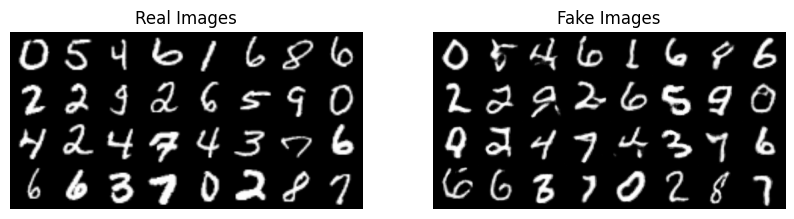

Saved Generator and Discriminator weights for epoch 1


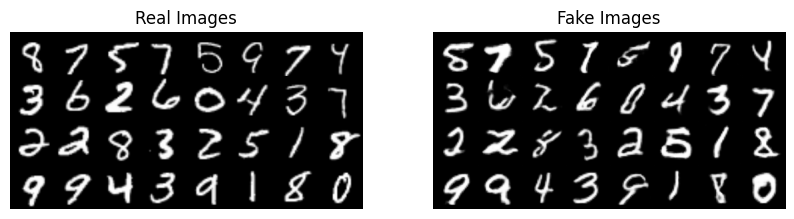

Saved Generator and Discriminator weights for epoch 6


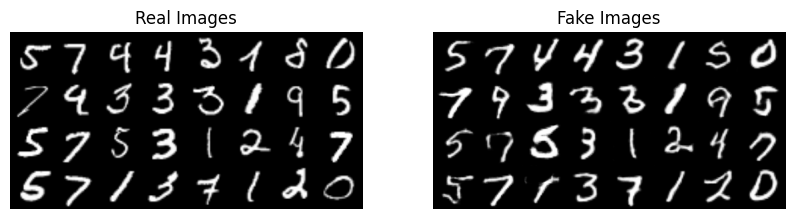

Saved Generator and Discriminator weights for epoch 11


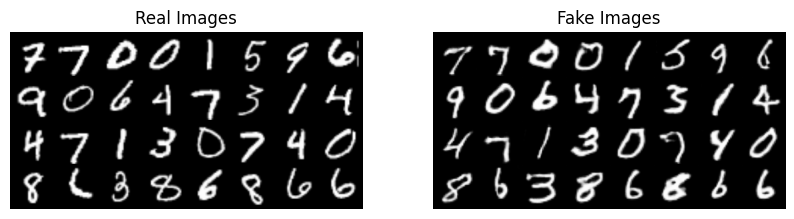

Saved Generator and Discriminator weights for epoch 16


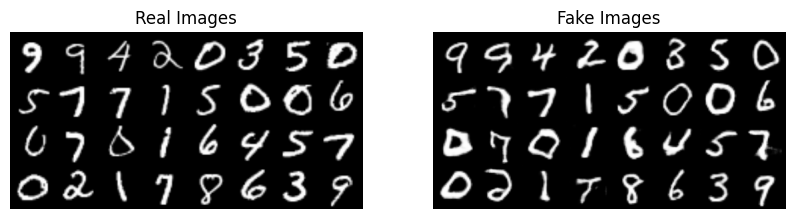

Saved Generator and Discriminator weights for epoch 21


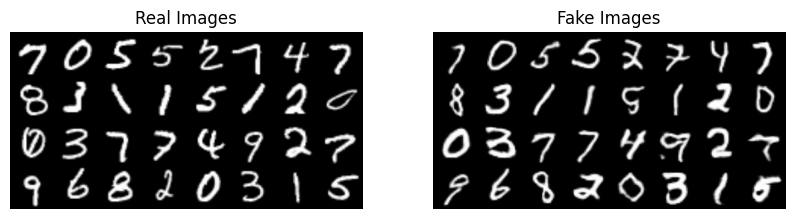

Saved Generator and Discriminator weights for epoch 26


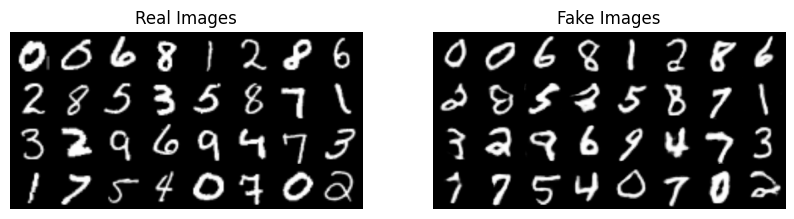

Saved Generator and Discriminator weights for epoch 31


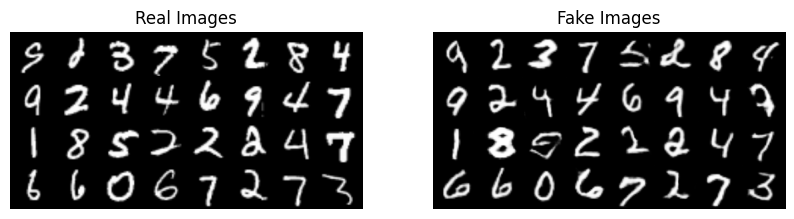

Saved Generator and Discriminator weights for epoch 36


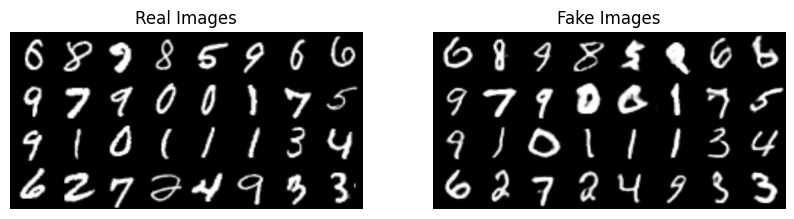

Saved Generator and Discriminator weights for epoch 41


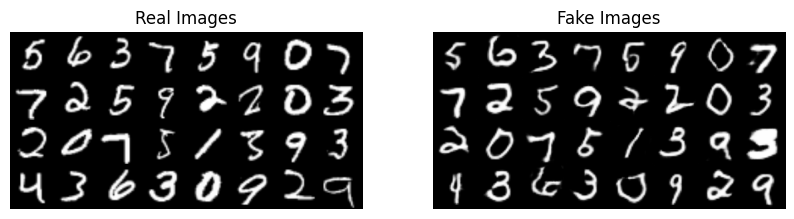

Saved Generator and Discriminator weights for epoch 46


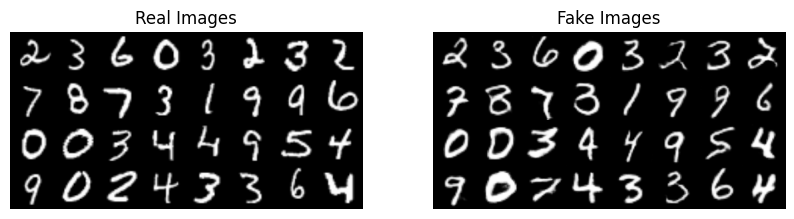

Saved Generator and Discriminator weights for epoch 51


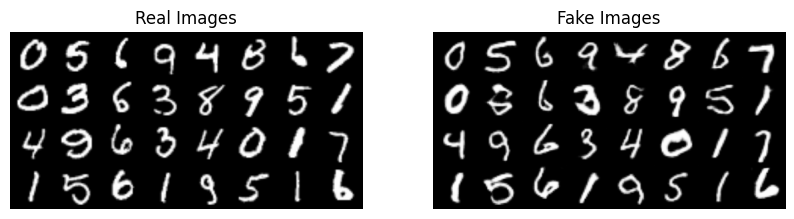

Saved Generator and Discriminator weights for epoch 56


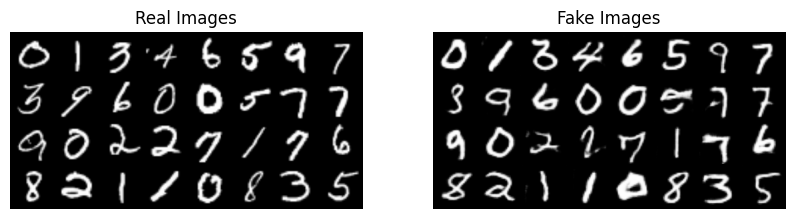

Saved Generator and Discriminator weights for epoch 61


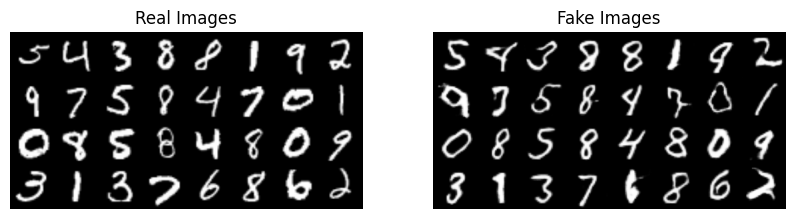

Saved Generator and Discriminator weights for epoch 66


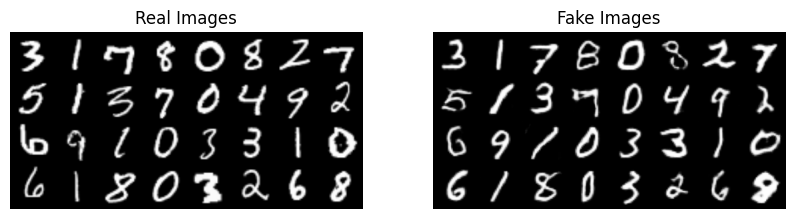

Saved Generator and Discriminator weights for epoch 71


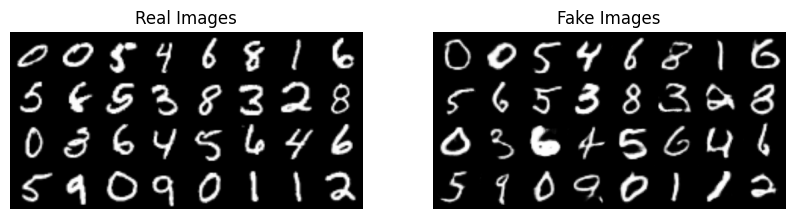

Saved Generator and Discriminator weights for epoch 76


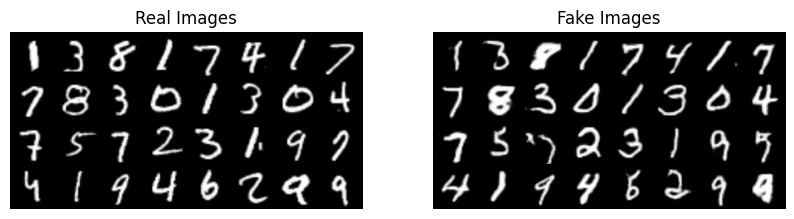

Saved Generator and Discriminator weights for epoch 81


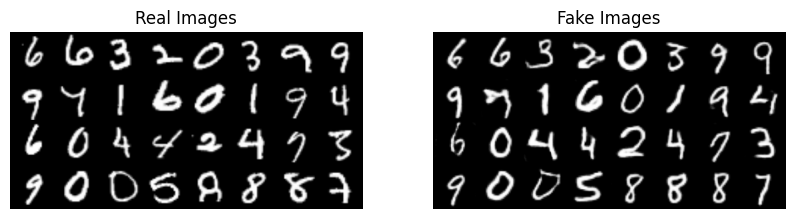

Saved Generator and Discriminator weights for epoch 86


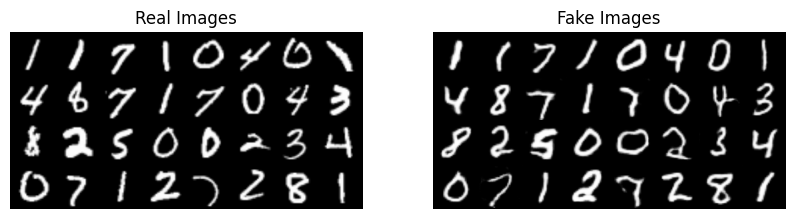

Saved Generator and Discriminator weights for epoch 91


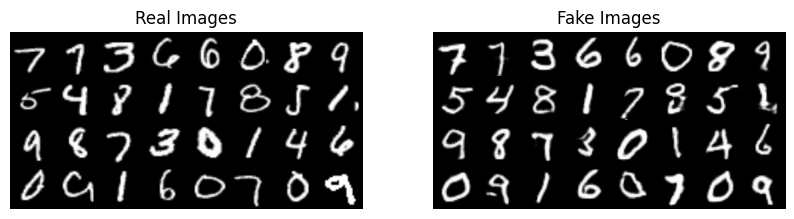

Saved Generator and Discriminator weights for epoch 96


In [39]:
gen.train()
disc.train()

for epoch in range(NUM_EPOCHS):
    # Target labels not needed! <3 unsupervised
    for batch_idx, (real, labels) in enumerate(loader):
        real = real.to(device)
        cur_batch_size = real.shape[0]
        labels = labels.to(device)

        # Train Critic: max E[disc(real)] - E[disc(fake)]
        # equivalent to minimizing the negative of that
        for _ in range(CRITIC_ITERATIONS):
            noise = torch.randn(cur_batch_size, Z_DIM, 1, 1).to(device)
            fake = gen(noise, labels)
            critic_real = disc(real, labels).reshape(-1)
            critic_fake = disc(fake, labels).reshape(-1)
            gp = gradient_penalty(disc, labels, real, fake, device=device)
            loss_critic = (
                -(torch.mean(critic_real) - torch.mean(critic_fake)) + LAMBDA_GP * gp
            )
            disc.zero_grad()
            loss_critic.backward(retain_graph=True)
            opt_disc.step()

        # Train Generator: max E[disc(gen_fake)] <-> min -E[disc(gen_fake)]
        gen_fake = disc(fake, labels).reshape(-1)
        loss_gen = -torch.mean(gen_fake)
        gen.zero_grad()
        loss_gen.backward()
        opt_gen.step()

        # Print losses occasionally and print to tensorboard
        if batch_idx % 100 == 0 and batch_idx > 0:
            # print(
            #     f"Epoch [{epoch}/{NUM_EPOCHS}] Batch {batch_idx}/{len(loader)} \
            #       Loss D: {loss_critic:.4f}, loss G: {loss_gen:.4f}"
            # )

            with torch.no_grad():
                fake = gen(noise, labels)
                # take out (up to) 32 examples
                img_grid_real = torchvision.utils.make_grid(real[:32], normalize=True)
                img_grid_fake = torchvision.utils.make_grid(fake[:32], normalize=True)
 
                writer_real.add_image("Real", img_grid_real, global_step=step)
                writer_fake.add_image("Fake", img_grid_fake, global_step=step)

            step += 1
            
    if epoch % 5 == 0:
        # Convert images from torch.Tensor to numpy array for plotting
        img_real = img_grid_real.permute(1, 2, 0).cpu().numpy()
        img_fake = img_grid_fake.permute(1, 2, 0).cpu().numpy()

        # Plot the real and fake images side by side
        plt.figure(figsize=(10, 5))
        plt.subplot(1, 2, 1)
        plt.title("Real Images")
        plt.imshow(img_real)
        plt.axis("off")

        plt.subplot(1, 2, 2)
        plt.title("Fake Images")
        plt.imshow(img_fake)
        plt.axis("off")

        plt.show()

        # Save model weights after each epoch
        gen_path = os.path.join(GEN_WEIGHTS_DIR, f"gen_epoch_{epoch+1}.pth")
        disc_path = os.path.join(DISC_WEIGHTS_DIR, f"disc_epoch_{epoch+1}.pth")
        
        torch.save(gen.state_dict(), gen_path)
        torch.save(disc.state_dict(), disc_path)
        print(f"Saved Generator and Discriminator weights for epoch {epoch+1}")
        

In [40]:
# Save model weights after each epoch
gen_path = os.path.join(GEN_WEIGHTS_DIR, f"gen_epoch_{epoch+1}.pth")
disc_path = os.path.join(DISC_WEIGHTS_DIR, f"disc_epoch_{epoch+1}.pth")

torch.save(gen.state_dict(), gen_path)
torch.save(disc.state_dict(), disc_path)
print(f"Saved Generator and Discriminator weights for epoch {epoch+1}")

Saved Generator and Discriminator weights for epoch 100


# Getting Pictures

C:\Users\pc\AppData\Local\Temp\ipykernel_3156\545091326.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  gen.load_state_dict(torch.load(os.path.join(GEN_WEIGHTS_DIR, f"ge

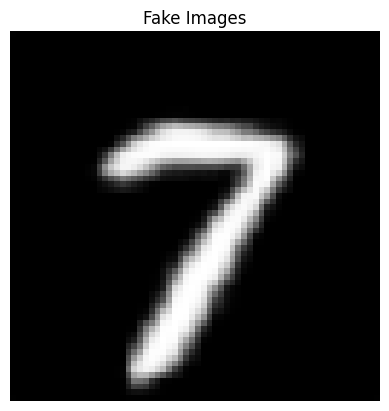

In [57]:
import numpy as np

user_input = 7

user_input = torch.tensor([user_input]).to(device)

noise = torch.randn(1, Z_DIM, 1, 1).to(device)

gen.load_state_dict(torch.load(os.path.join(GEN_WEIGHTS_DIR, f"gen_epoch_100.pth")))
gen.to(device)  # Move Generator to the device
gen.eval()

with torch.no_grad():
    generated = gen(noise, user_input)

    img = generated[0].permute(1, 2, 0).cpu().numpy()

    # img = (img * 255).astype(np.uint8)
    img = (img + 1) / 2.0

    # # Ensure the image is in [0, 1] range
    # img = np.clip(img, 0.0, 1.0)
    img = (img - img.min()) / (img.max() - img.min())

    plt.title("Fake Images")
    plt.imshow(img, cmap='gray')
    plt.axis("off")

    plt.show()

In [142]:
import streamlit as st

# Streamlit app
def main():
    st.title("GAN Image Generator")
    
    gen = Generator(Z_DIM, CHANNELS_IMG, FEATURES_GEN, NUM_CLASSES, IMAGE_SIZE, GEN_EMBEDDING).to(device)
    gen.load_state_dict(torch.load(os.path.join(GEN_WEIGHTS_DIR, f"gen_epoch_100.pth")))
    gen.eval()

    # Slider for user input
    user_input = st.slider("Select a number", 0, 9, 0)

    # Generate image when button is pressed
    if st.button("Generate Image"):
        noise = torch.randn(1, Z_DIM, 1, 1).to(device)
        user_input_tensor = torch.tensor([user_input]).to(device)
        
        with torch.no_grad():
            generated = gen(noise, user_input_tensor)
            img = generated[0].permute(1, 2, 0).cpu().numpy()
            img = (img * 255).astype(np.uint8)  # Convert from [-1, 1] to [0, 255]

            # Display the image
            st.image(img, caption=f"Generated Image for class {user_input}", use_column_width=True)

if __name__ == "__main__":
    main()

C:\Users\pc\AppData\Local\Temp\ipykernel_3148\3617116076.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  gen.load_state_dict(torch.load(os.path.join(GEN_WEIGHTS_DIR, f"g